In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce GTX 1650 Ti


Using device: cuda


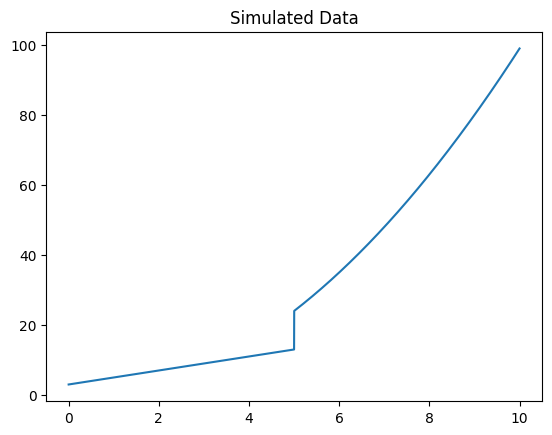

In [3]:
# Here I will define my simulated data as a piecewise function
# Generate 10000 datapoints
X_train = np.linspace(0, 10, 10000).reshape(-1, 1)
y_train = np.zeros(len(X_train))

# Apply piecewise function
for i in range(0, int(len(X_train)/2)):
    y_train[i] = 2 * X_train[i][0] + 3  

for j in range(int(len(X_train)/2), len(X_train)):
    y_train[j] = X_train[j][0] ** 2 - 1  

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert to PyTorch tensors and move data to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

# Dataset and DataLoader (use mini-batches of 128)
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)  

# Plot data to visualize function
plt.plot(X_train.cpu().numpy(), y_train.cpu().numpy())
plt.title("Simulated Data")
plt.show()


In [4]:
# Define Neural network class

class NeuralNetwork(nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(1, 128)     # Input layer
        self.layer2 = nn.Linear(128, 64)    # Hidden layer
        self.output = nn.Linear(64,1)       # Output layer

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output(x)
        return x

In [5]:
# Initialize model
model = NeuralNetwork().to(device)

# Loss function. Use mean-squared error for now:
criterion = nn.MSELoss()

#Optimizer: Adam. Adjust lr
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch [100/1000], Loss: 2.3849
Epoch [200/1000], Loss: 0.5862
Epoch [300/1000], Loss: 0.3961
Epoch [400/1000], Loss: 0.3462
Epoch [500/1000], Loss: 0.3374
Epoch [600/1000], Loss: 0.2316
Epoch [700/1000], Loss: 0.4624
Epoch [800/1000], Loss: 0.3887
Epoch [900/1000], Loss: 0.3950
Epoch [1000/1000], Loss: 0.2687


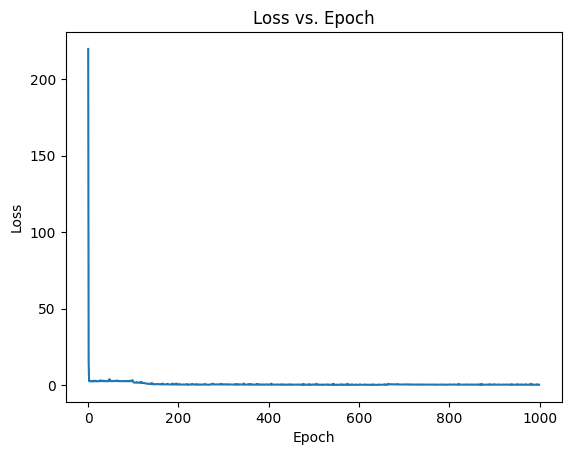

In [6]:
# Number of epochs
epochs = 1000
loss_values = []

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    
    for X_batch, y_batch in dataloader:  # Iterate over mini-batches
        # Move the batch data to the correct device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass: compute the model output
        outputs = model(X_batch)

        # Compute the loss
        loss = criterion(outputs, y_batch.view(-1, 1))  # Reshape target to match prediction

        # Backward pass and optimization
        optimizer.zero_grad()   # Zero the gradients
        loss.backward()         # Backpropagate the loss
        optimizer.step()        # Adjust weights

        # Accumulate the loss for this batch
        epoch_loss += loss.item()

    # Store average loss value for this epoch
    avg_loss = epoch_loss / len(dataloader)
    loss_values.append(avg_loss)

    # Print the average loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

# Plot loss values over epochs
plt.plot(range(epochs), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()


C:\Users\kiena\AppData\Local\Temp\ipykernel_3476\3343833834.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(range(epochs)), np.log(loss_values))


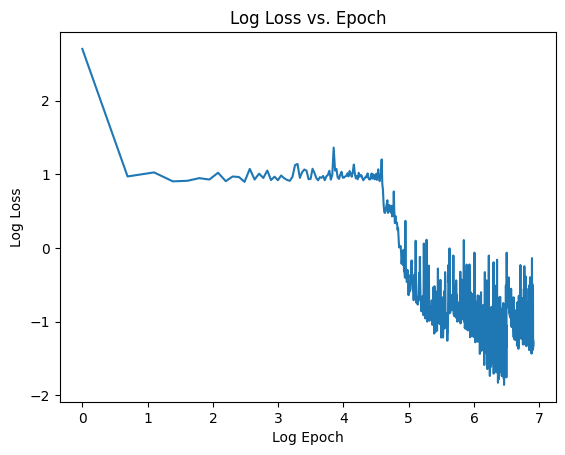

In [7]:
plt.plot(np.log(range(epochs)), np.log(loss_values))
plt.xlabel('Log Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss vs. Epoch')
plt.show()

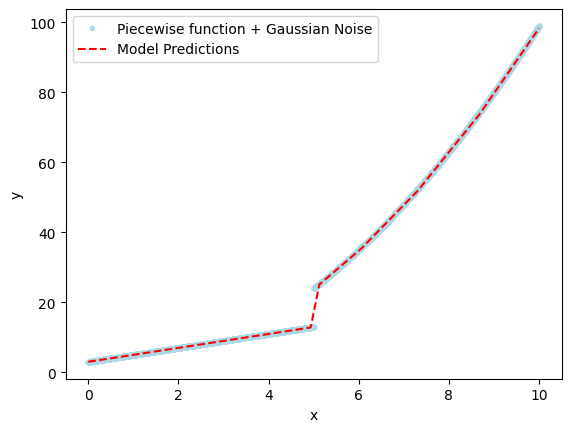

In [8]:
# Set the model to evaluation mode
model.eval()

# Generate predictions (detach from computation graph)
with torch.no_grad():
    # Move X_train to the correct device for the model, if not already
    predictions = model(X_train).cpu().numpy()  # Move to CPU and convert to NumPy

# Convert X_train and y_train to NumPy for plotting
X_train_np = X_train.cpu().numpy()  # Move to CPU
y_train_np = y_train.cpu().numpy()  # Move to CPU

# Plot results
plt.plot(X_train_np, y_train_np, linestyle='None', marker='.', label="Piecewise function + Gaussian Noise", color="lightblue")
plt.plot(X_train_np, predictions, label="Model Predictions", linestyle='dashed', color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
